* Name: `dissipation-theory--Study-18.ipynb`
* Author: John A. Marohn
* Date: 2024-06-02
* Continued from: `dissipation-theory--Study-17.ipynb`
* Continued to: ---
* Summary: Turn the BLDS fitting code in `dissipation-theory--Study-17.ipynb` into functions that can be looped over data.

In [1]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation import blds_perpendicular_jit
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd

In [3]:
from lmfit import Model, Parameters

In [4]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [5]:
THIS = 'dissipation-theory--Study-18--'

# PM6:Y6/ITO data set 2

In [6]:
filepath = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','ito','pm6-y6-ito-2']

In [7]:
database2 = {}
database2['A'] = {'filename': '230531-085452-BLDS-pm6-y6-3-dark.tsv', 'I [mW/cm^2]' : 0}
database2['B'] = {'filename': '230531-085907-BLDS-pm6-y6-3-50mA.tsv', 'I [mW/cm^2]' : 0.84}
database2['C'] = {'filename': '230531-090350-BLDS-pm6-y6-3-56mA.tsv', 'I [mW/cm^2]' : 5.4}
database2['D'] = {'filename': '230531-090844-BLDS-pm6-y6-3-61mA.tsv', 'I [mW/cm^2]' : 54}
database2['E'] = {'filename': '230531-091339-BLDS-pm6-y6-3-66mA.tsv', 'I [mW/cm^2]' : 103}
database2['F'] = {'filename': '230531-091846-BLDS-pm6-y6-3-71mA.tsv', 'I [mW/cm^2]' : 154}

# Code to work up the data

In [8]:
class BLDSData(object):

    def __init__(self, THIS, filepath, database):

        self.THIS = THIS
        self.database = database
        self.findings = {}
        self.plotkey = None
        self.guess = False
        self.fitted = False

        for key in database.keys():
    
            path = os.path.join(os.path.join(*filepath), database[key]['filename'])
            df = pd.read_csv(path, sep='\t')
        
            x = df['Modulation Frequency [Hz]'].to_numpy()
            y1 = df['Mean Freq [Hz]'].to_numpy()
            y2r = df['X-Channel [Hz]'].to_numpy()
            y2i = df['Y-Channel [Hz]'].to_numpy()
            y2m = np.sqrt(y2r**2 + y2i**2)
        
            self.database[key]['x'] = x
            self.database[key]['abs(y1)'] = abs(y1)
            self.database[key]['y2m'] = y2m

    def plotdata(self, plotkey='abs(y1)'):

        self.plotkey = plotkey
        fig, axes = plt.subplots(
            figsize=(len(self.database) * 2.00 + 1.00, 2.50),
            ncols=len(self.database),
            sharey=True)

        for index, key in enumerate(self.database.keys()):

            x = self.database[key]['x']
            y = self.database[key][plotkey]
            
            lbl = r'$I_{h \nu}$ = ' + '{:0.1f} mW/cm$^2$'.format(self.database[key]['I [mW/cm^2]'])
            axes[index].set_title(lbl, fontsize=12)
            axes[index].semilogx(x, y, marker = 'o', fillstyle='none', linestyle='none')
            axes[index].set_xticks([1e3,1e5])
            axes[index].set_xlabel('$\omega_{\mathrm{m}}$ [rad/s]')
            axes[index].grid()
            
            if self.guess or self.fitted:
                axes[index].semilogx(self.database[key]['x'], self.database[key]['y_calc'], '-')
                
        axes[0].set_ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
        fig.tight_layout()
        
        return fig
        
    def fitfunc(self, x, separation, mobility, density):

        sample_jit = SampleModel1Jit(
            cantilever = CantileverModelJit(
                f_c = 75e3, 
                V_ts = 1.0,
                R = 30e-9,  # really think 30 nm
                d = separation * 1e-9),
            h_s = 110e-9, 
            epsilon_s = complex(3.4, 0),
            mu = mobility * 1e-8,
            rho = density * 1e21,
            epsilon_d = complex(1e6, 0),
            z_r = separation * 1e-9
        )
        
        omega_m = ureg.Quantity(x, 'Hz')
        blds = ureg.Quantity(np.zeros_like(x), 'Hz')
        for index, omega_ in enumerate(omega_m):
                blds[index] = 0.50 * blds_perpendicular_jit(theta1norm_jit, sample_jit, omega_).to('Hz')
        
        return abs(blds.to('Hz').magnitude)

    def fitguess(self, separation, mobility, density):

        self.guess = True
        self.separation = separation
        self.mobility = mobility
        self.mobility = density

        for key in self.database.keys():
            self.database[key]['y_calc'] = self.fitfunc(self.database[key]['x'], separation, mobility, density)

    def fit(self):

        # Set up the fit
        
        self.fitted=True
        gmodel = Model(self.fitfunc)

        pars= Parameters() 
        pars.add('separation', value=self.separation, min=50, max=500)
        pars.add('mobility', value=self.mobility, min=0.01, max=100)
        pars.add('density', value=self.mobility, min=0.01, max=100)

        # Loop over all keys and fit the blds data
        
        for key in self.database.keys():

            print('fitting dataset {:}'.format(key))

            result = gmodel.fit(
                self.database[key][self.plotkey],
                x=self.database[key]['x'],
                params=pars)
            
            self.database[key]['result'] = result
            self.database[key]['y_calc'] = result.best_fit
            self.database[key]['values'] = {
                'separation': ureg.Quantity(result.params['separation'].value, 'nm'),
                'mobility': ureg.Quantity(1e-8 * result.params['mobility'].value, 'm^2/(V s)'),
                'density': ureg.Quantity(1e21 * result.params['density'].value, '1/m^3')}            
            self.database[key]['stderr'] = {
                'separation': ureg.Quantity(result.params['separation'].stderr, 'nm'),
                'mobility': ureg.Quantity(1e-8 * result.params['mobility'].stderr, 'm^2/(V s)'),
                'density': ureg.Quantity(1e21 * result.params['density'].stderr, '1/m^3')}
       
        # Create conductivity dictionary containing intensities and conductivity (values and error bars) 
        # with units. Compute a conductivity error bar by propagating error
        
        I_val = ureg.Quantity(np.zeros(len(self.database)), 'mW/cm^2')
        cond_val = ureg.Quantity(np.zeros(len(self.database)), 'mS/m')
        cond_err = ureg.Quantity(np.zeros(len(self.database)), 'mS/m')
        
        for index, key in enumerate(self.database.keys()):
        
            I_val[index] =  ureg.Quantity(self.database[key]['I [mW/cm^2]'], 'mW/cm^2')
            
            mu_val = self.database[key]['values']['mobility']
            rho_val = self.database[key]['values']['density']
            
            cond_val[index] = qe * mu_val * rho_val
        
            mu_err = self.database[key]['stderr']['mobility']
            rho_err = self.database[key]['stderr']['density']
            
            cond_err[index] = cond_val[index] * np.sqrt((mu_err/mu_val)**2 + (rho_err/rho_val)**2)

        self.findings['conductivity'] = {'x': I_val, 'y': cond_val, 'yerr': cond_err}

       # Create dictionary of separation, mobility, and density
       # There is some rearranging to do, from a list of items with units, 
       # to a numpy array with one unit for the whole array.
  
        for finding in ['separation', 'mobility', 'density']:
            unit = self.database[key]['values'][finding].units
            y = np.array([self.database[key]['values'][finding].to(unit).magnitude for key in D2.database.keys()])
            yerr = np.array([self.database[key]['stderr'][finding].to(unit).magnitude for key in D2.database.keys()])
            
            self.findings[finding] = {
                'x': I_val,
                'y': ureg.Quantity(y, unit),
                'yerr': ureg.Quantity(yerr, unit)
            }

    def plotfindings(self):
        
        fig, axes = plt.subplots(figsize=(10.0, 2.50), ncols=4)
        opts = dict(marker='o', mfc='w', ms=4, capsize=3, linestyle='none')
        
        for index, finding in enumerate(self.findings.keys()):
        
            if finding == 'conductivity':
                ylabel=r'$\sigma$ [$\mu$S/m]'
                yunit='uS/m'
                ydiv=1
            elif finding == 'separation':
                ylabel=r'$d$ [nm]'
                yunit='nm'
                ydiv=1
            elif finding == 'mobility':
                ylabel=r'$\mu$ [$10^{-5}$ cm$^2$/(V s)]'
                yunit='cm^2/(V s)'
                ydiv=1e-5
            elif finding == 'density':
                ylabel=r'$\rho$ [$10^{16}$ cm$^{-3}$]'
                yunit='1/cm^3'
                ydiv=1e16
                
            axes[index].errorbar(
                self.findings[finding]['x'].to('mW/cm^2').magnitude, 
                self.findings[finding]['y'].to(yunit).magnitude/ydiv,
                yerr=self.findings[finding]['yerr'].to(yunit).magnitude /ydiv,
                **opts)
        
            # axes[index].set_xscale('log')
            axes[index].set_ylabel(ylabel)
            axes[index].set_xlabel(r'$I_{h \nu}$ [mW/cm$^2$]')
            axes[index].grid()
        
        fig.tight_layout()
        
        return fig

# PM6:Y6/ITO data set 2 workup

In [9]:
D2 = BLDSData(THIS, filepath, database2)

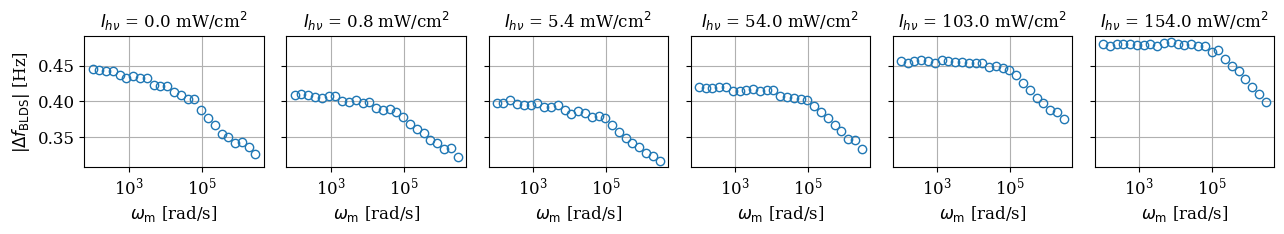

In [10]:
f = {} # dictionary to store the figures in
f['01']=D2.plotdata()

We are going to use one initial guess for all the data.  Iterate the calculated curve goes through at least one of the data sets.

In [11]:
D2.fitguess(235, 0.4, 20)

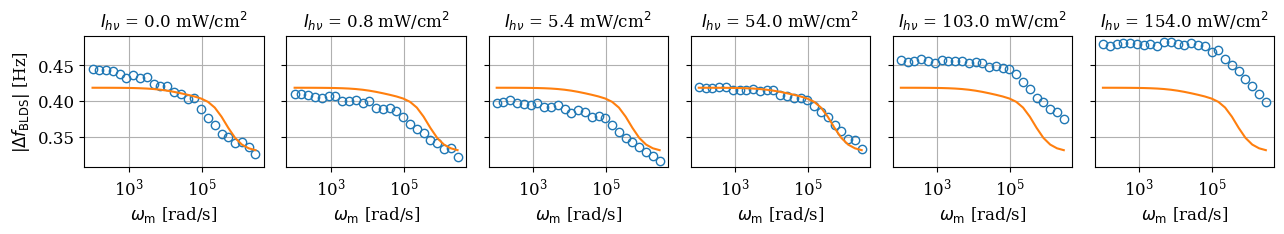

In [12]:
f['02']=D2.plotdata()

Fitting the data takes a few minutes.

In [13]:
D2.fit()

fitting dataset A
fitting dataset B
fitting dataset C
fitting dataset D
fitting dataset E
fitting dataset F


Let's see how good the fit looks

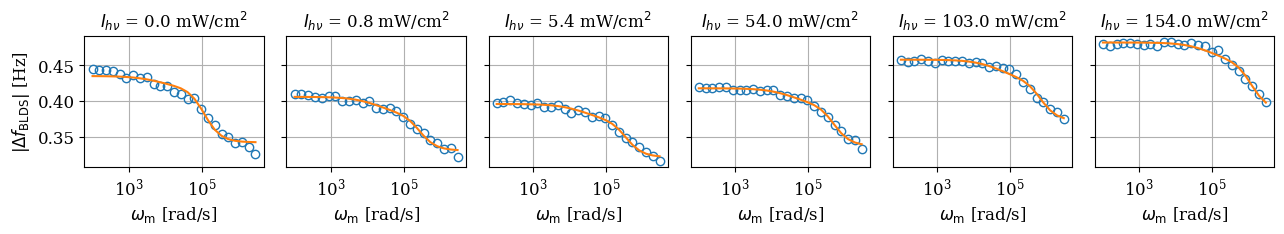

In [14]:
f['03']=D2.plotdata()

Plot the findings.

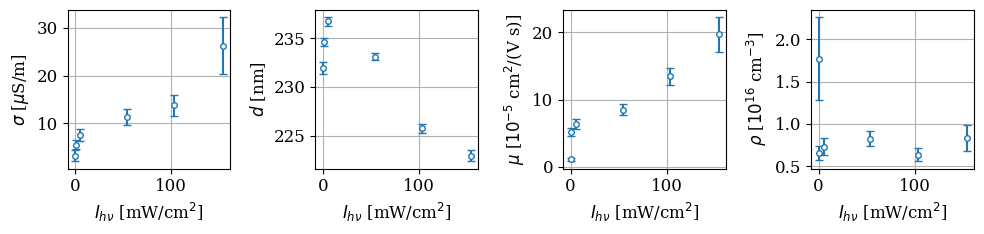

In [15]:
f['04']=D2.plotfindings()

### PM:Y6/ITO dataset 1 workup

* I tried dataset 3, but the `71mA` data gave huge error bars.
* I tried dataset 4, but it was too slopey at low modulation frequency.

In [16]:
filepath1 = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','ito','pm6-y6-ito-1']

database1 = {}
database1['A'] = {'filename': '230530-094142-BLDS-pm6-y6-dark.tsv', 'I [mW/cm^2]' : 0}
database1['B'] = {'filename': '230530-094620-BLDS-pm6-y6-50mA.tsv', 'I [mW/cm^2]' : 0.84}
database1['C'] = {'filename': '230530-095350-BLDS-pm6-y6-56mA.tsv', 'I [mW/cm^2]' : 5.4}
database1['D'] = {'filename': '230530-095855-BLDS-pm6-y6-61mA.tsv', 'I [mW/cm^2]' : 54}
database1['E'] = {'filename': '230530-100342-BLDS-pm6-y6-66mA.tsv', 'I [mW/cm^2]' : 103}
database1['F'] = {'filename': '230530-100850-BLDS-pm6-y6-71mA.tsv', 'I [mW/cm^2]' : 154}

In [17]:
D1 = BLDSData(THIS, filepath1, database1)

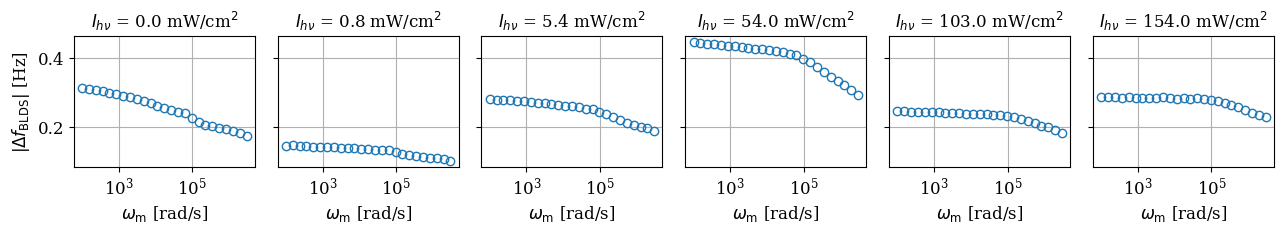

In [18]:
f['05']=D1.plotdata()

In [19]:
D1.fitguess(300, 0.3, 20)

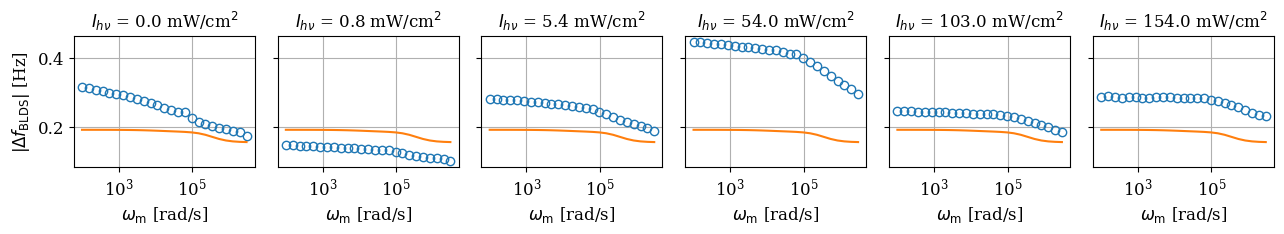

In [20]:
f['06']=D1.plotdata()

In [21]:
D1.fit()

fitting dataset A
fitting dataset B
fitting dataset C
fitting dataset D
fitting dataset E
fitting dataset F


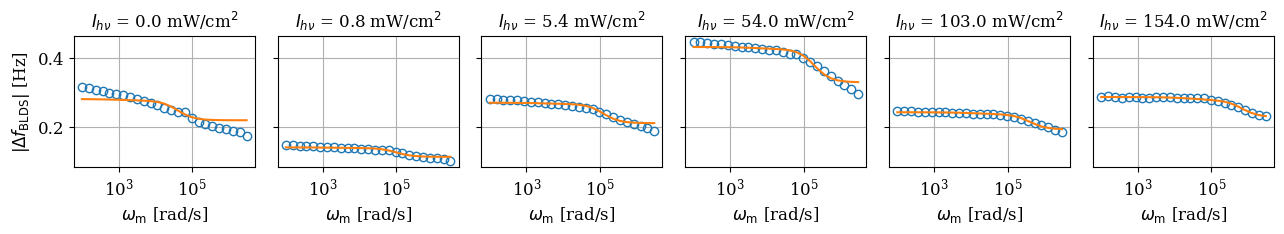

In [85]:
f['07']=D1.plotdata()

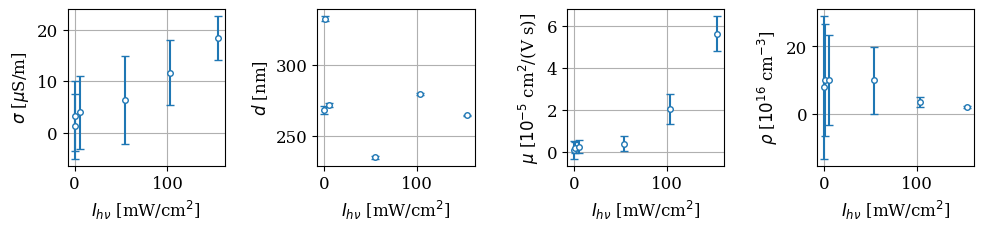

In [86]:
f['08']=D1.plotfindings()

# PM6:Y6/PEDOT-PSS

## Dataset 1

In [59]:
filepath1b = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','pedot-pss','pm6-y6-pedot-pss-1']

database1b = {}
database1b['A'] = {'filename': '231004-104235-BLDS-pm6-y6-pedot-pss-1-dark.tsv', 'I [mW/cm^2]' : 0}
database1b['B'] = {'filename': '231004-104658-BLDS-pm6-y6-pedot-pss-1-50mA.tsv', 'I [mW/cm^2]' : 0.84}
database1b['C'] = {'filename': '231004-105211-BLDS-pm6-y6-pedot-pss-1-56mA.tsv', 'I [mW/cm^2]' : 5.4}
database1b['D'] = {'filename': '231004-105718-BLDS-pm6-y6-pedot-pss-1-61mA.tsv', 'I [mW/cm^2]' : 54}
database1b['E'] = {'filename': '231004-110206-BLDS-pm6-y6-pedot-pss-1-66mA.tsv', 'I [mW/cm^2]' : 103}
database1b['F'] = {'filename': '231004-110655-BLDS-pm6-y6-pedot-pss-1-71mA.tsv', 'I [mW/cm^2]' : 154}

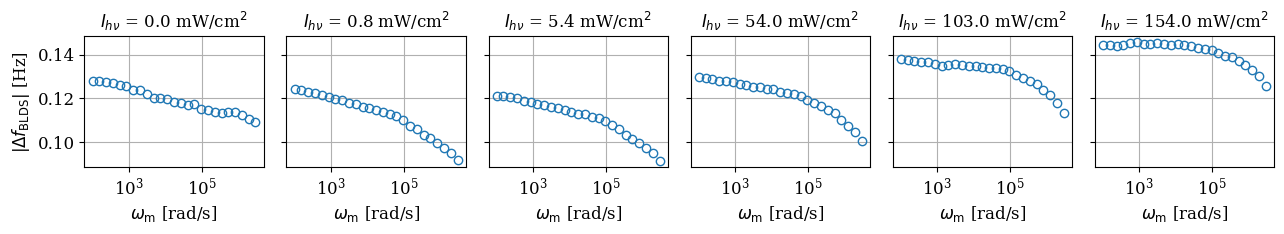

In [60]:
D1b = BLDSData(THIS, filepath1b, database1b)
f['09'] = D1b.plotdata()

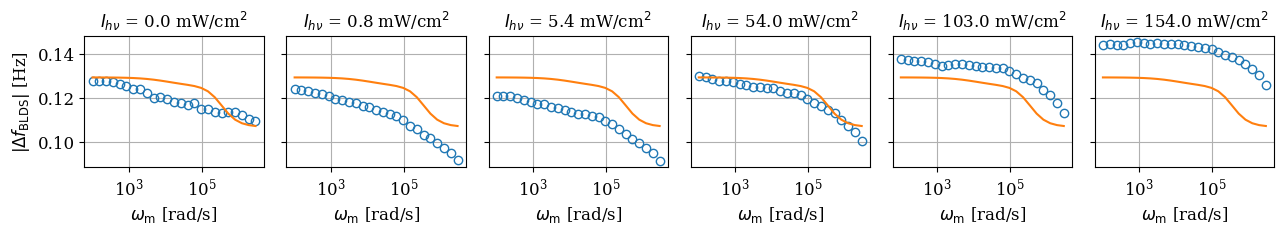

In [61]:
D1b.fitguess(340, 0.3, 20)
f['10'] = D1b.plotdata()

fitting dataset A
fitting dataset B
fitting dataset C
fitting dataset D
fitting dataset E
fitting dataset F


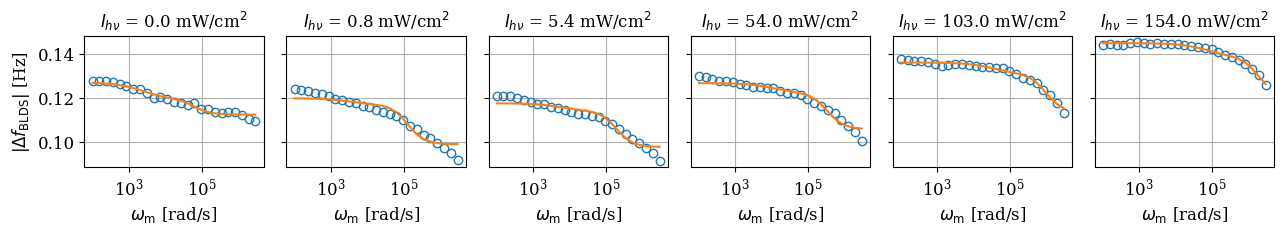

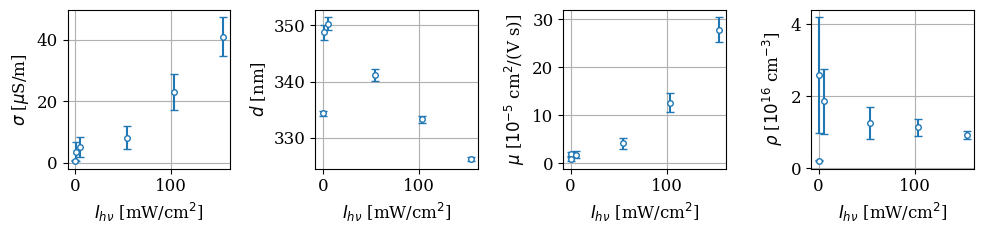

In [62]:
D1b.fit()
f['11']=D1b.plotdata()
f['12']=D1b.plotfindings()

## Dataset 2

In [63]:
filepath2b = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','pedot-pss','pm6-y6-pedot-pss-2']

database2b = {}
database2b['A'] = {'filename': '231004-083809-BLDS-pm6-y6-pedot-pss-2-dark.tsv', 'I [mW/cm^2]' : 0}
database2b['B'] = {'filename': '231004-084501-BLDS-pm6-y6-pedot-pss-2-50mA.tsv', 'I [mW/cm^2]' : 0.84}
database2b['C'] = {'filename': '231004-085008-BLDS-pm6-y6-pedot-pss-2-56mA.tsv', 'I [mW/cm^2]' : 5.4}
database2b['D'] = {'filename': '231004-085506-BLDS-pm6-y6-pedot-pss-2-61mA.tsv', 'I [mW/cm^2]' : 54}
database2b['E'] = {'filename': '231004-090005-BLDS-pm6-y6-pedot-pss-2-66mA.tsv', 'I [mW/cm^2]' : 103}
database2b['F'] = {'filename': '231004-090503-BLDS-pm6-y6-pedot-pss-2-71mA.tsv', 'I [mW/cm^2]' : 154}

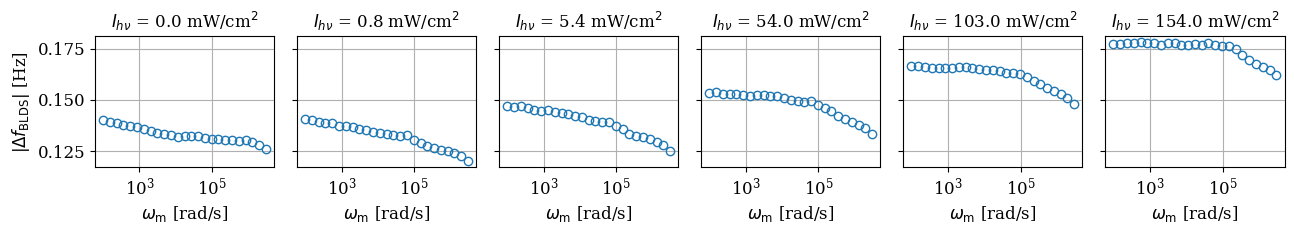

In [64]:
D2b = BLDSData(THIS, filepath2b, database2b)
f['13'] = D2b.plotdata()

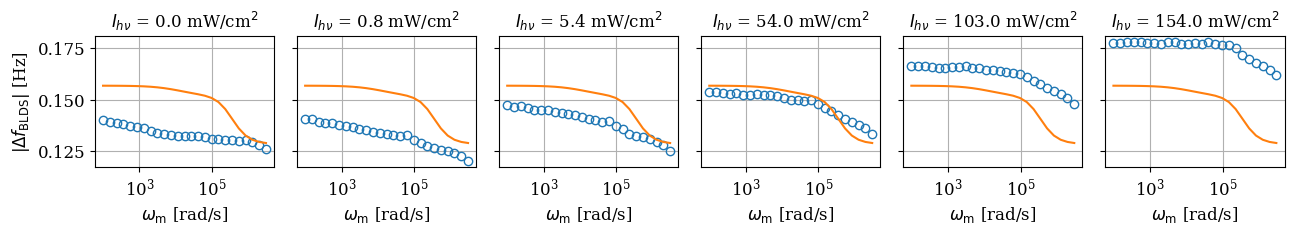

In [65]:
D2b.fitguess(320, 0.3, 20)
f['14'] = D2b.plotdata()

fitting dataset A
fitting dataset B
fitting dataset C
fitting dataset D
fitting dataset E
fitting dataset F


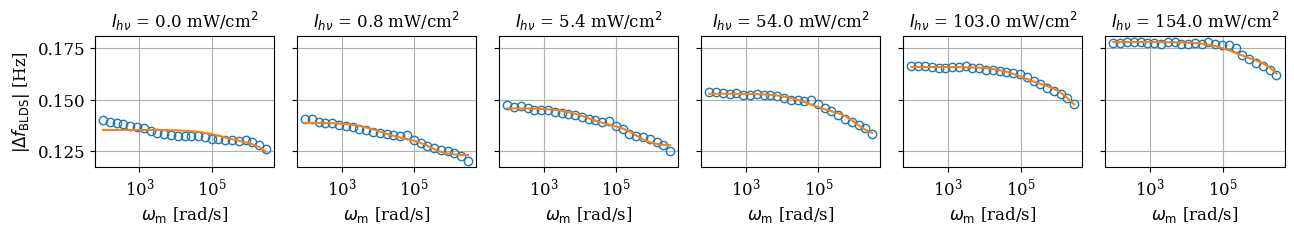

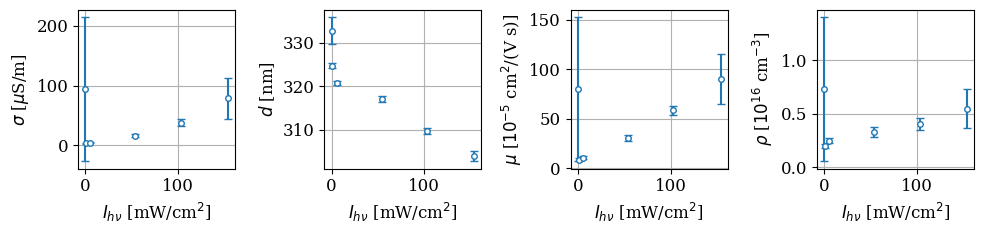

In [66]:
D2b.fit()
f['15']=D2b.plotdata()
f['16']=D2b.plotfindings()

## Dataset 3

In [67]:
filepath3b = ['~','Dropbox','EFM_Data_workup','pm6-y6-paper-blds-data','pm6-y6','pedot-pss','pm6-y6-pedot-pss-3']

database3b = {}
database3b['A'] = {'filename': '231004-095307-BLDS-pm6-y6-pedot-pss-3-dark.tsv', 'I [mW/cm^2]' : 0}
database3b['B'] = {'filename': '231004-095754-BLDS-pm6-y6-pedot-pss-3-50mA.tsv', 'I [mW/cm^2]' : 0.84}
database3b['C'] = {'filename': '231004-100245-BLDS-pm6-y6-pedot-pss-3-56mA.tsv', 'I [mW/cm^2]' : 5.4}
database3b['D'] = {'filename': '231004-100740-BLDS-pm6-y6-pedot-pss-3-61mA.tsv', 'I [mW/cm^2]' : 54}
database3b['E'] = {'filename': '231004-101225-BLDS-pm6-y6-pedot-pss-3-66mA.tsv', 'I [mW/cm^2]' : 103}
database3b['F'] = {'filename': '231004-101719-BLDS-pm6-y6-pedot-pss-3-71mA.tsv', 'I [mW/cm^2]' : 154}

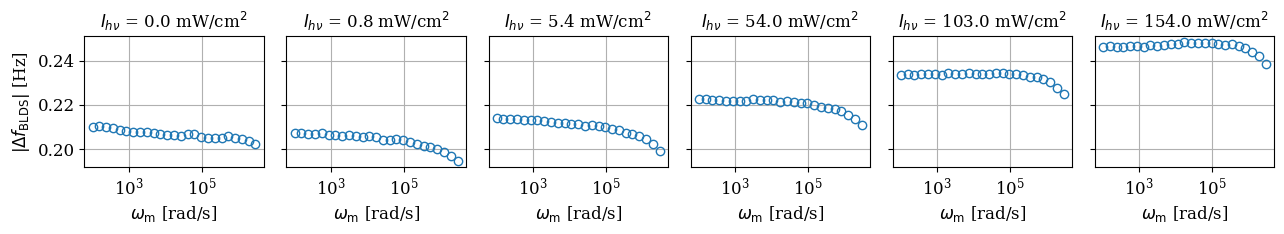

In [68]:
D3b = BLDSData(THIS, filepath3b, database3b)
f['17'] = D3b.plotdata()

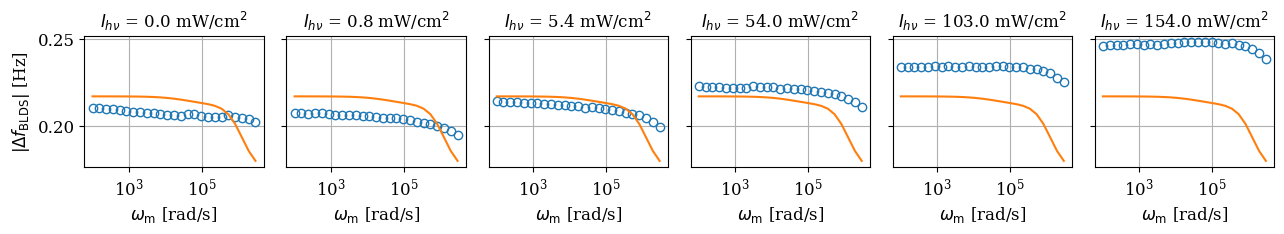

In [69]:
D3b.fitguess(290, 0.6, 40)
f['18'] = D3b.plotdata()

fitting dataset A
fitting dataset B
fitting dataset C
fitting dataset D
fitting dataset E
fitting dataset F


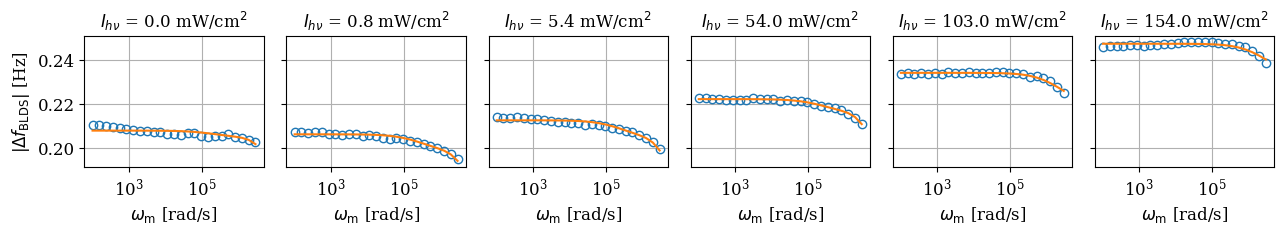

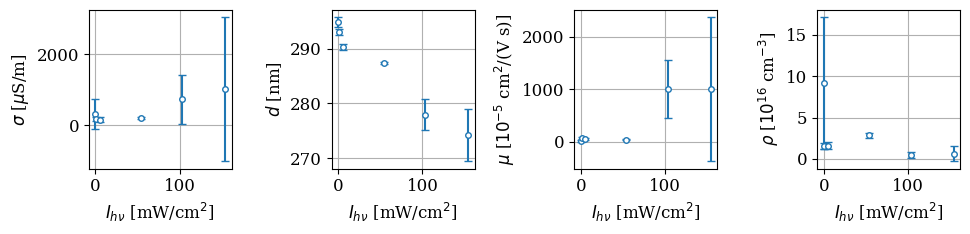

In [70]:
D3b.fit()
f['19']=D3b.plotdata()
f['20']=D3b.plotfindings()

# Summary of findings

## PM6:Y6/ITO (two data sets)

### BLDS fits

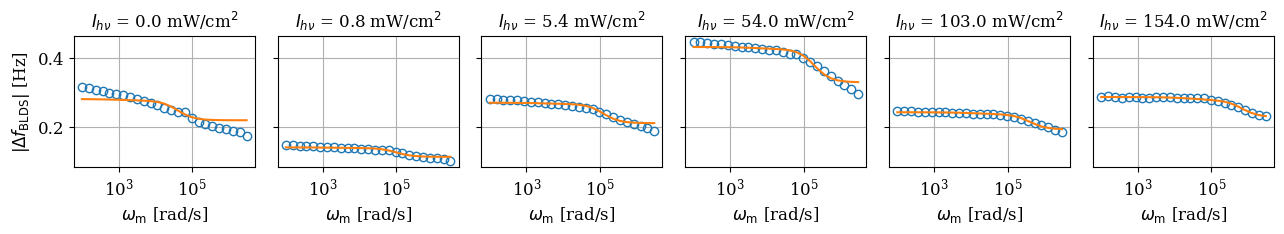

In [97]:
f['07']

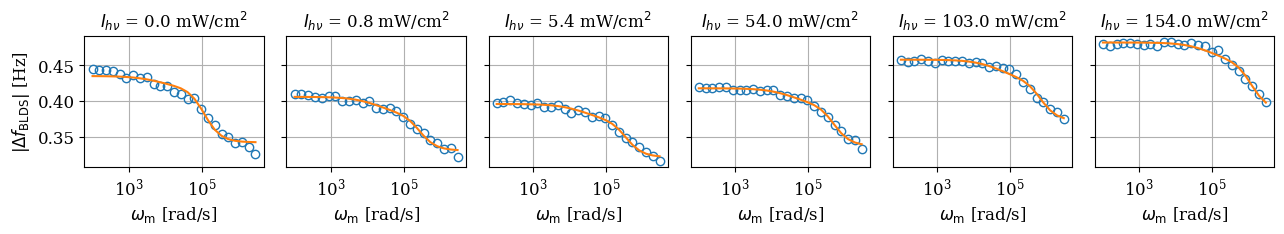

In [98]:
f['03']

## Findings

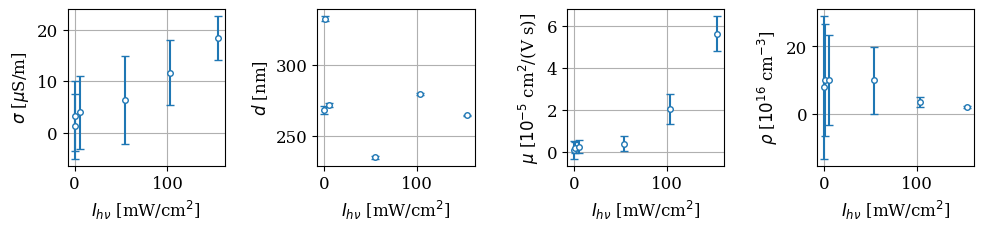

In [99]:
f['08']

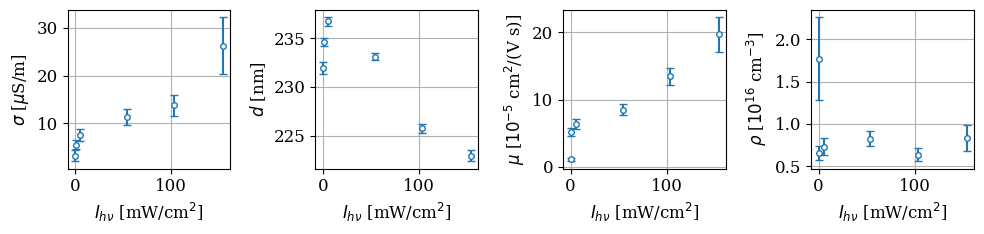

In [100]:
f['04']

## PM6:Y6/ITO (three data sets)

### BLDS fits

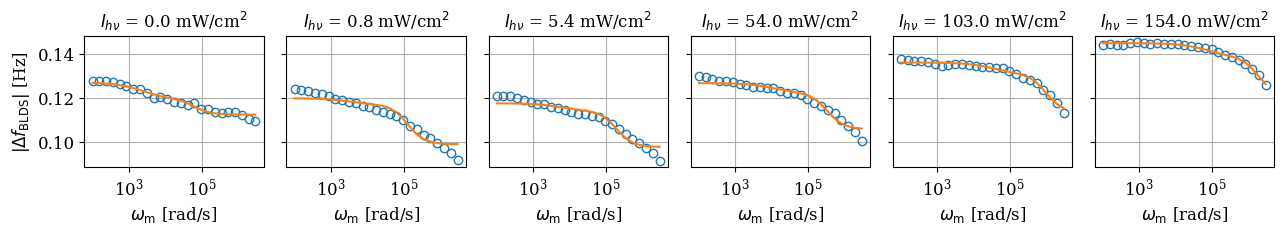

In [101]:
f['11']

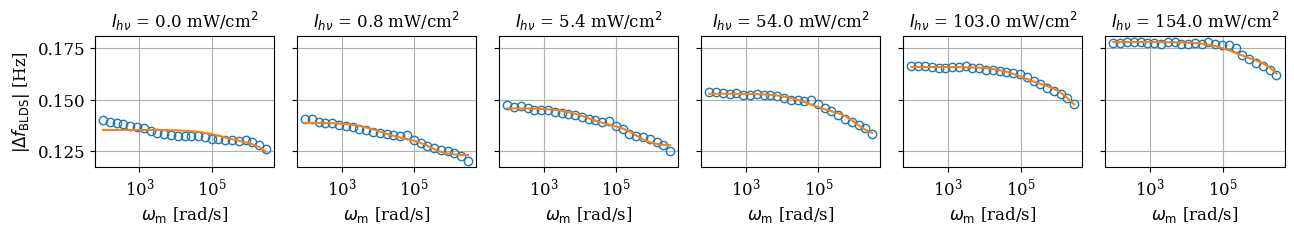

In [102]:
f['15']

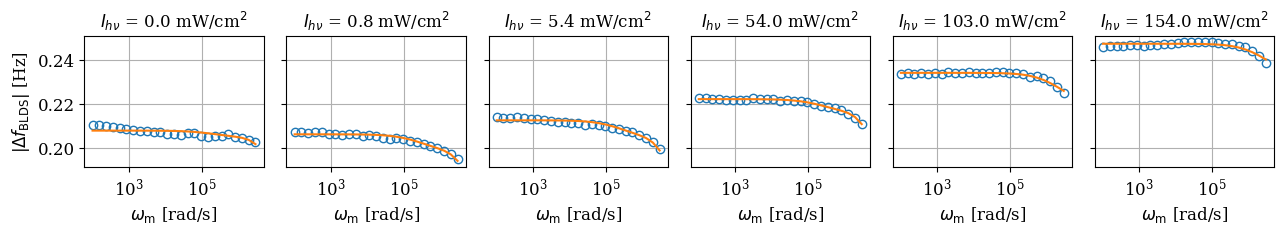

In [103]:
f['19']

### Findings

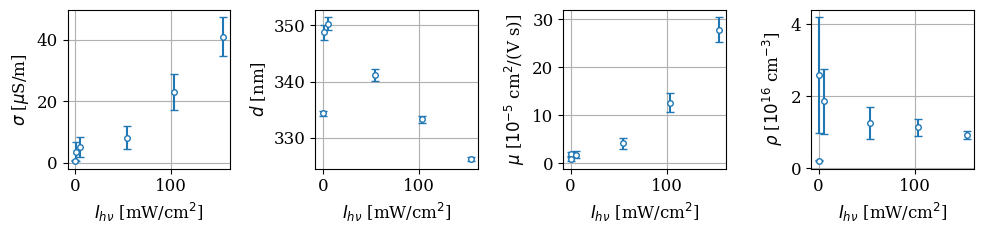

In [104]:
f['12']

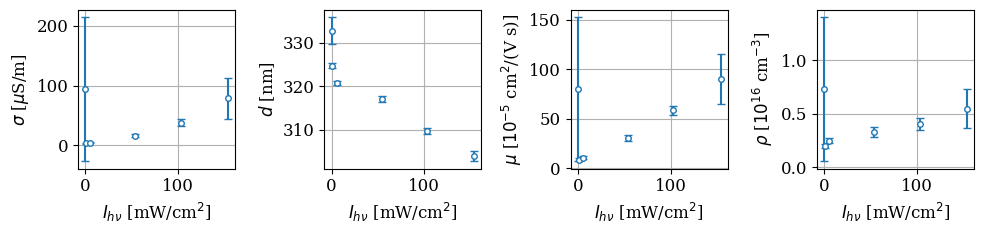

In [105]:
f['16']

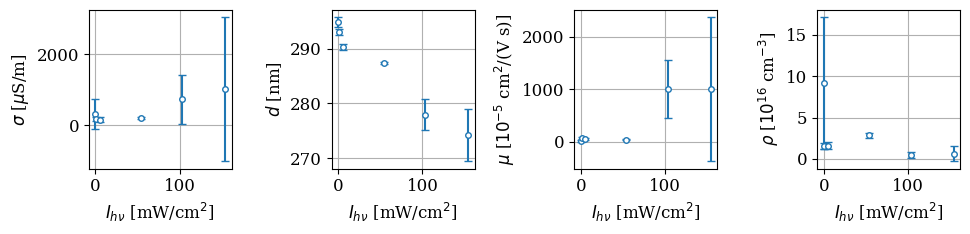

In [106]:
f['20']

# Discussion

* The estimated conductivity is three orders of magnitude smaller than we previously estimated using Dwyer's theory ($\mu$S/m now, versus mS/m before).
* The size of the signal is very sensitive to the tip-sample separation $d$.
* Drift in the tip-sample separation $d$ is clearly a big factor.
* **WARNING** When calculating the conductivity $\sigma$, I am not taking into account the correlation of the mobility $\mu$ and the charge density $\rho$.

# Export selected figures

In [108]:
for num in ['07','03','08','04','11','15','19','12','16','20']:
    figname = THIS + "Fig-" + num
    f[num].savefig(figname + '.png', dpi=300)
    f[num].savefig(figname + '.pdf')